## Prelogue
This notebook contains some researches about our model perfomance. Briefly:
* We discovered, that image scale is crucial for getting qualitive predictions.
* We compared quality of one-image-prediction and 4-image-averege prediction. For every pinned spike in dataset there were made four images and we compared is it better to predict pubescence using every image separately or take 4 projection from each side of spike, compute mean of predicted labels and make decision.

In [76]:
from config import PROJECT_DIR, DATA_DIR, PATTERNS, HOLDOUT_BASE_DIR
from training_config import training_params, augmentations
from dataset import SpikeDataset, HoldoutDataset, balance_dataset
from model import Model

from tqdm import tqdm
import numpy as np
import torch
import os
import cv2
import time
import random
import re
from matplotlib import pyplot as plt
from sklearn import metrics 

Load our dataset

In [77]:
data_source = 'first_split_renewed.csv'
train_data = SpikeDataset(data_source, 'train')
valid_data = SpikeDataset(data_source, 'valid')
test_data = SpikeDataset(data_source, 'test', verbose=True)
dataset = torch.utils.data.ConcatDataset([train_data, valid_data, test_data])

### Split data into bins according to the area of colorchecker

In [78]:
mask_dir = f'{PROJECT_DIR}/masks'

In [79]:
def split_data(dataset, n_bins=1, thresh=None):
    areas = np.zeros((len(dataset), 2))
    for i in tqdm(range(len(dataset))):
        img_info = dataset[i][2]
        img_type = img_info['img_type']
        species = img_info['species']
        ploidy = img_info['ploidness']
        img_name = re.search(PATTERNS[img_type], img_info['img_path']).group()
            
        # replace substrings
        rep = {'jpg': 'png', 'JPG': 'png'}
        rep = {re.escape(k) : v for k, v in rep.items()}
        pattern = re.compile('|'.join(rep.keys()))
        mask_name = pattern.sub(lambda m: rep[re.escape(m.group(0))], img_name)
            
        # read mask
        mask_path = f'{mask_dir}/{ploidy}/{img_type}/{mask_name}'
        mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
        mask = np.moveaxis(mask, -1, 0)
            
        # compute area of colorchecker
        _, y_shape, x_shape = mask.shape
        checker = np.zeros((y_shape, x_shape), dtype='uint8')
        checker = mask[0]
            
        # compute relative area of colorchecker
        area = np.count_nonzero(checker) / (x_shape*y_shape)
        areas[i, 0] = area
        areas[i, 1] = i
        
    # split areas into n_bins
    areas = list(areas)
    areas = sorted(areas, key=lambda arr: arr[0])
    if not thresh:
        splits = np.array_split(np.array(areas), n_bins)
    else:
        areas = np.array(areas)
        splits = []
        splits.append(areas[np.where(areas[:, 0] < thresh)])
        splits.append(areas[np.where(areas[:, 0] >= thresh)])
        splits = np.array(splits)
    return areas, splits

In [80]:
areas, splits = split_data(test_data, thresh=0.1)

100%|██████████| 1135/1135 [02:52<00:00,  6.57it/s]
/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:41: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.


In [81]:
# scheck percent of data by splits
for spt in splits:
    print(len(spt) / len(test_data))

0.7894273127753304
0.2105726872246696


In [82]:
areas[:, 0]

array([0.06265843, 0.06567038, 0.06570565, ..., 0.35671976, 0.36541818,
       0.39134196])

Let's check hystograms for areas

In [83]:
areas = np.array(areas)

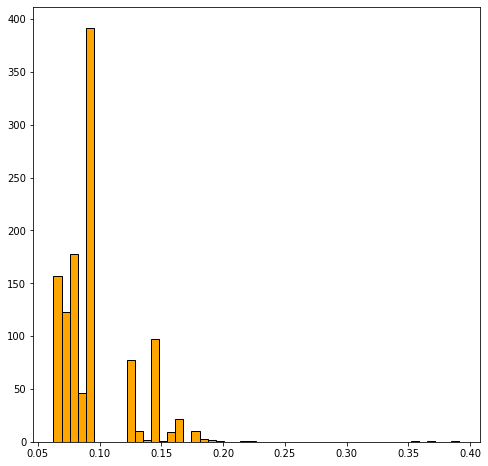

In [84]:
fig = plt.figure(figsize=(8, 8))
_ = plt.hist(areas[:, 0], bins=50, color='orange', edgecolor="black")
# plt.savefig('relative_area_hist.png')

Select min and max areas and show their masks to compare

In [85]:
min_idx = int(splits[0][0, 1])
max_idx = int(splits[1][-1, 1])

In [86]:
def get_checker_mask(idx):
    img_info = test_data[idx][2]
    img_type = img_info['img_type']
    species = img_info['species']
    ploidy = img_info['ploidness']
    img_name = re.search(PATTERNS[img_type], img_info['img_path']).group()
            
    # replace substrings
    rep = {'jpg': 'png', 'JPG': 'png'}
    rep = {re.escape(k) : v for k, v in rep.items()}
    pattern = re.compile('|'.join(rep.keys()))
    mask_name = pattern.sub(lambda m: rep[re.escape(m.group(0))], img_name)
            
    # read mask
    mask_path = f'{mask_dir}/{ploidy}/{img_type}/{mask_name}'
    mask = cv2.imread(str(mask_path), cv2.IMREAD_UNCHANGED)
    mask = np.moveaxis(mask, -1, 0)
    _, y_shape, x_shape = mask.shape
    checker = np.zeros((y_shape, x_shape), dtype='uint8')
    checker = mask[0]
    return checker

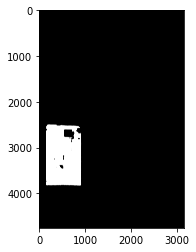

In [87]:
plt.imshow(get_checker_mask(min_idx), cmap='gray')

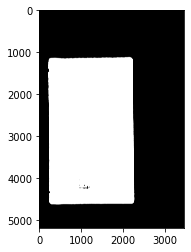

In [88]:
plt.imshow(get_checker_mask(max_idx), cmap='gray')

Now Let's test our best model

In [89]:
save_path = f'{PROJECT_DIR}/runs'
model_name = 'efficientnet_b1'
model_class = Model(model_name, save_path)

In [90]:
model_class.load('best_manual')

Load model and dataoaders

In [91]:
from torch.utils.data import SubsetRandomSampler, DataLoader

In [92]:
test_data_compressed = SpikeDataset(data_source, 'test', verbose=False)
metrics = []

for spt in splits:
    # create sampler
    idxs = spt[:, 1].astype('int')
    sampler = SubsetRandomSampler(idxs)
    
    # percent of overall data
    percent_data = len(spt) / len(test_data_compressed)
    print(f'Split with percent of data: {percent_data:.3f}')
    tmp = model_class.inference(test_data_compressed, sampler=sampler)
    metrics.append(tmp.copy())
    print()

Split with percent of data: 0.789
accuracy_score: 0.8571428571428571
precision_score: 0.6826086956521739
roc_auc_score: 0.8902750193092795
loss: 0.570510978760819

Split with percent of data: 0.211
accuracy_score: 0.8535564853556485
precision_score: 0.6813186813186813
roc_auc_score: 0.9288785689714482
loss: 0.4507480833757597



In [93]:
metrics

[{'accuracy_score': 0.8571428571428571,
  'precision_score': 0.6826086956521739,
  'roc_auc_score': 0.8902750193092795,
  'loss': 0.570510978760819},
 {'accuracy_score': 0.8535564853556485,
  'precision_score': 0.6813186813186813,
  'roc_auc_score': 0.9288785689714482,
  'loss': 0.4507480833757597}]

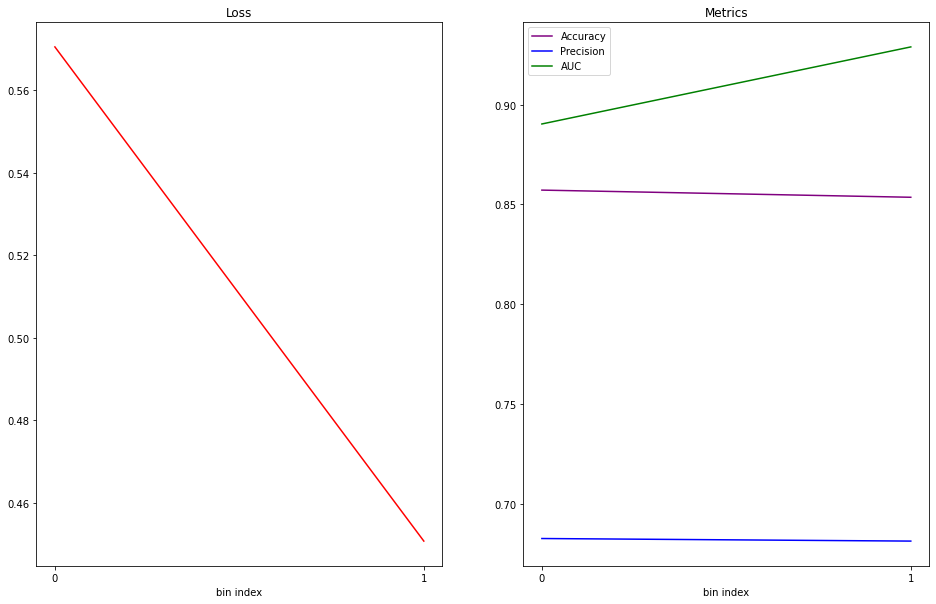

In [95]:
x = [0, 1]
accuracy = [metrics[i]['accuracy_score'] for i in range(len(metrics))]
loss = [metrics[i]['loss'] for i in range(len(metrics))]
precision = [metrics[i]['precision_score'] for i in range(len(metrics))]
auc = [metrics[i]['roc_auc_score'] for i in range(len(metrics))]

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
            
# plot losses

# fig.suptitle('Absolute area', fontsize=14)
for i in range(2):
    axs[i].set_xticks(range(0,2))
axs[0].set_title('Loss')
axs[0].plot(x, loss, color='red')          
    
axs[1].set_title('Metrics')
axs[1].plot(x, accuracy, color='purple', label = 'Accuracy')        
axs[1].plot(x, precision, color='blue', label = 'Precision')
axs[1].plot(x, auc, color='green', label = 'AUC')
plt.legend()


for i in range(2):
    axs[i].set_xlabel('bin index')
plt.savefig('scale_and_predicitons_of_test_1_split.png')

Now we want to split data and check if rotation impacts on predictions

In [101]:
def split_by_projection(dataset):
    projections = [[] for i in range(4)]
    for i in tqdm(range(len(dataset))):
        verb_dict = dataset[i][2]
        img_path = verb_dict['img_path']
        img_name = re.search(PATTERNS['pin'], img_path)
        img_type = verb_dict['img_type']
        
        if not img_name:
            continue
        else:
            img_name = img_name.group()
            pattern = r'_[1-4]_'
            raw_res = re.search(pattern, img_name).group()
            pattern = r'[1-4]'
            prj_type = int(re.search(pattern, raw_res).group()) - 1
            projections[prj_type].append(i)
    
    return projections

In [102]:
splits = split_by_projection(test_data)

100%|██████████| 1135/1135 [00:07<00:00, 149.15it/s]


In [106]:
test_data_compressed = SpikeDataset(data_source, 'test', verbose=False)
metrics = []

for spt in splits:
    # create sampler
    sampler = SubsetRandomSampler(spt)
    
    tmp = model_class.inference(test_data_compressed, sampler=sampler)
    metrics.append(tmp.copy())

accuracy_score: 0.8678414096916299
precision_score: 0.7166666666666667
roc_auc_score: 0.9004803675856308
loss: 0.585929599722404
accuracy_score: 0.8546255506607929
precision_score: 0.6885245901639344
roc_auc_score: 0.889515455304929
loss: 0.5757489263647106
accuracy_score: 0.8458149779735683
precision_score: 0.6666666666666666
roc_auc_score: 0.8824143692564745
loss: 0.6239822685203932
accuracy_score: 0.8678414096916299
precision_score: 0.7241379310344828
roc_auc_score: 0.9121762740183792
loss: 0.4667662926685085


In [107]:
metrics

[{'accuracy_score': 0.8678414096916299,
  'precision_score': 0.7166666666666667,
  'roc_auc_score': 0.9004803675856308,
  'loss': 0.585929599722404},
 {'accuracy_score': 0.8546255506607929,
  'precision_score': 0.6885245901639344,
  'roc_auc_score': 0.889515455304929,
  'loss': 0.5757489263647106},
 {'accuracy_score': 0.8458149779735683,
  'precision_score': 0.6666666666666666,
  'roc_auc_score': 0.8824143692564745,
  'loss': 0.6239822685203932},
 {'accuracy_score': 0.8678414096916299,
  'precision_score': 0.7241379310344828,
  'roc_auc_score': 0.9121762740183792,
  'loss': 0.4667662926685085}]

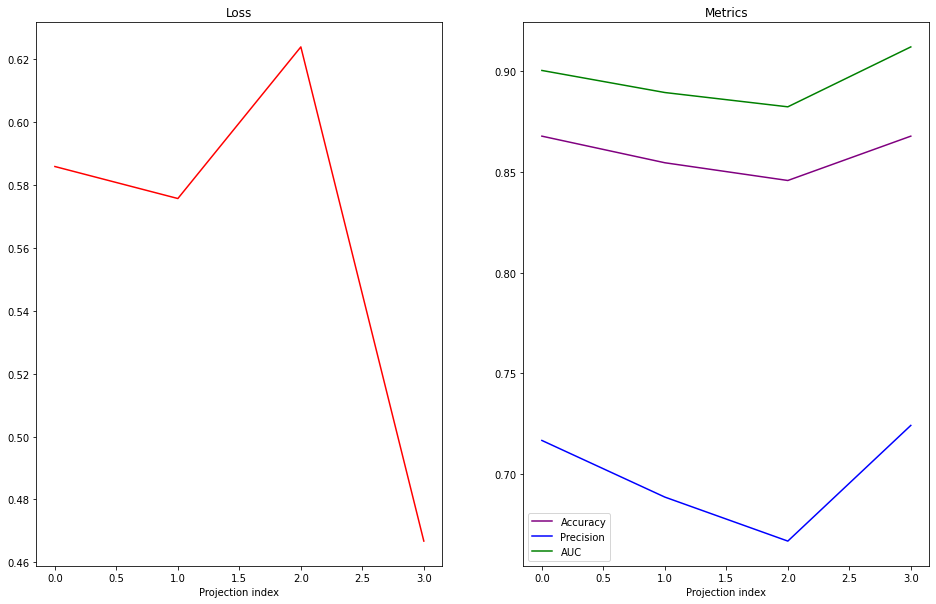

In [109]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(16, 10))
            
# plot losses
x = np.arange(0, len(splits))
accuracy = [metrics[i]['accuracy_score'] for i in range(len(metrics))]
loss = [metrics[i]['loss'] for i in range(len(metrics))]
precision = [metrics[i]['precision_score'] for i in range(len(metrics))]
auc = [metrics[i]['roc_auc_score'] for i in range(len(metrics))]


# fig.suptitle('Absolute area', fontsize=14)
axs[0].set_title('Loss')
axs[0].plot(x, loss, color='red')          
    
axs[1].set_title('Metrics')
axs[1].plot(x, accuracy, color='purple', label = 'Accuracy')        
axs[1].plot(x, precision, color='blue', label = 'Precision')
axs[1].plot(x, auc, color='green', label = 'AUC')
plt.legend()

for i in range(2):
    axs[i].set_xlabel('Projection index')

## Predictions by projections voting

In [7]:
from itertools import groupby

We have to write function that split our dataset 

In [112]:
def group_by_projection(dataset):
    unique_names = {}
    for i in tqdm(range(len(dataset))):
        verb_dict = dataset[i][2]
        img_path = verb_dict['img_path']
        img_name = re.search(PATTERNS['pin'], img_path)
        img_type = verb_dict['img_type']
        
        if not img_name:
            continue
        else:
            img_name = img_name.group()
            pattern = r'_[1-4]_'
            raw_res = re.search(pattern, img_name).group()
            name = re.sub(pattern, '', img_name)
            if not name in unique_names.keys():
                unique_names[name] = [i]
            else:
                unique_names[name].append(i)
    return unique_names

In [114]:
splits = group_by_projection(test_data)

100%|██████████| 1135/1135 [00:07<00:00, 146.70it/s]


In [116]:
splits

{'293{Х-20}.jpg': [0, 7, 12, 20],
 '294{Х-20}.jpg': [1, 4, 13, 18],
 '298{Х-20}.jpg': [2, 8, 14, 22],
 '292{Х-20}.jpg': [3, 5, 6, 17],
 '297{Х-20}.jpg': [9, 11, 19, 21],
 '291{Х-20}.jpg': [10, 15, 16, 23],
 '303{Х-20}.jpg': [24, 25, 26, 38],
 '301{Х-20}.jpg': [27, 29, 36, 40],
 '310{Х-20}.jpg': [28, 31, 34, 41],
 '304{Х-20}.jpg': [30, 33, 37, 43],
 '305{Х-20}.jpg': [32, 35, 39, 42],
 '328{Х-20}.jpg': [44, 48, 50, 70],
 '321{Х-20}.jpg': [45, 46, 67, 68],
 '325{Х-20}.jpg': [47, 55, 57, 60],
 '323{Х-20}.jpg': [49, 52, 56, 66],
 '322{Х-20}.jpg': [51, 61, 65, 71],
 '329{Х-20}.jpg': [53, 62, 64, 69],
 '324{Х-20}.jpg': [54, 58, 59, 63],
 '316{Х-20}.jpg': [72, 73, 77, 86],
 '313{Х-20}.jpg': [74, 79, 89, 90],
 '314{Х-20}.jpg': [75, 85, 88, 91],
 '319{Х-20}.jpg': [76, 78, 83, 84],
 '318{Х-20}.jpg': [80, 81, 82, 87],
 '331{Х-20}.jpg': [92, 97, 99, 101],
 '332{Х-20}.jpg': [93, 94, 95, 100],
 '334{Х-20}.jpg': [96, 98, 102, 103],
 '139{II-20}.jpg': [104, 105, 106, 107],
 '281{Х-20}.jpg': [108, 111, 

Now we will do the same, but we will use .predict() from model class

In [119]:
labels = np.zeros(len(splits))
predictions = np.zeros(len(splits))

for i, spt in enumerate(splits.values()):
    # form list of images:
    imgs = [test_data[j][0] for j in spt]
    preds = model_class.predict_proba(imgs)
    predicted_proba = preds.mean()
    
    # add data into arrays
    labels[i] = test_data[spt[0]][1]
    predictions[i] = predicted_proba

In [120]:
from sklearn.metrics import accuracy_score, precision_score, roc_auc_score

In [121]:
print(f'Accuracy: {accuracy_score(labels, predictions.round()):.2f}')
print(f'AUC: {roc_auc_score(labels, predictions):.2f}')
print(f'Precision: {precision_score(labels, predictions.round()):.2f}')

Accuracy: 0.89
AUC: 0.91
Precision: 0.75


# Heatmaps with/without dilation

In [2]:
from preprocessing import get_mask, get_bbox
from training_config import augmentations

In [3]:
data_source = 'first_split_renewed.csv'
train_data = SpikeDataset(data_source, 'train')
valid_data = SpikeDataset(data_source, 'valid')
test_data = SpikeDataset(data_source, 'test', verbose=True)
holdout_data = HoldoutDataset('holdout_annotation.csv', 'test', verbose=True)
dataset = torch.utils.data.ConcatDataset([train_data, valid_data, test_data])

Load model

In [38]:
save_path = f'{PROJECT_DIR}/runs'
model_name = 'efficientnet_b1'
model_class = Model(model_name, save_path)
model_class.load('best_manual')

In [39]:
holdout_data_nonverb = HoldoutDataset('holdout_annotation.csv', 'test')
test_data_nonverb = SpikeDataset(data_source, 'test')
model_class.inference(holdout_data_nonverb)

accuracy_score: 0.825
precision_score: 0.782608695652174
roc_auc_score: 0.8925000000000001
loss: 0.7109013929067259


{'accuracy_score': 0.825,
 'precision_score': 0.782608695652174,
 'roc_auc_score': 0.8925000000000001,
 'loss': 0.7109013929067259}

pick random image and show heatmap

In [56]:
# only for verbose holdout dataset!
def get_heatmap(idx, dilation=False):
    tmp = 'без опушения'
    label = 0
    if idx > 20:
        tmp = 'с опушением'
        label = 1
        idx = idx % 21
    base_path = f'{HOLDOUT_BASE_DIR}опушение/{tmp}'
    mask_path = f'{HOLDOUT_BASE_DIR}masks/опушенные' if label == 1 else f'{HOLDOUT_BASE_DIR}masks/неопушенные'
    img_name = os.listdir(base_path)[idx]
    img_path = f'{base_path}/{img_name}'
    mask_path = f'{mask_path}/{img_name.replace("jpg", "png")}'
    
    mask = cv2.imread(mask_path)
    img = cv2.imread(img_path)
    
    bbox = get_bbox(img, mask, dilation=dilation)
    final_img = augmentations['inference_transforms'](image=bbox)['image']
    final_img = np.moveaxis(final_img, -1, 0)
    
    model_class.class_activation_map(final_img, label)

9


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target is: 0
Prediction is: 0


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Target is: 0
Prediction is: 0


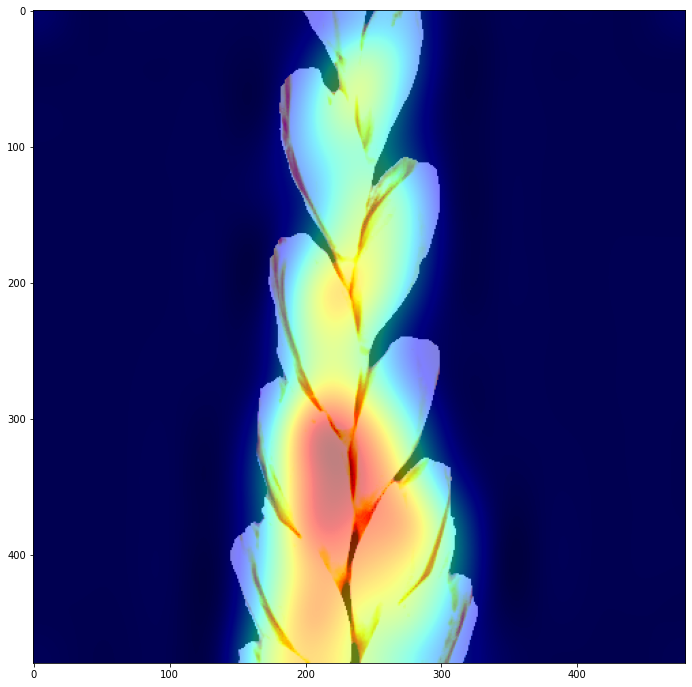

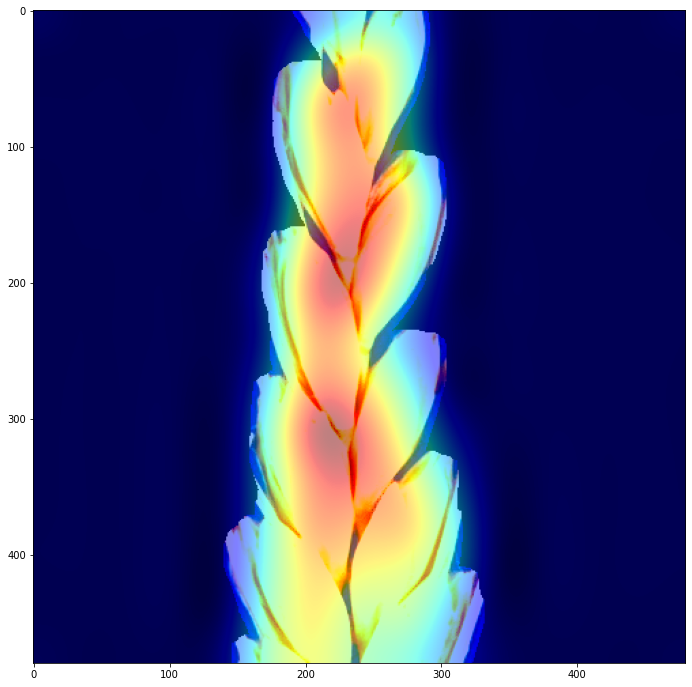

In [72]:
# 29.
# idx = random.randint(0, len(holdout_data))
idx = 9
print(idx)
get_heatmap(idx)
get_heatmap(idx, dilation=True)